In [ ]:
# MBTI-LSTM. Обучение модели. Google Colab

---

Классификация типов личности MBTI на основе текстов из социальных сетей с использованием LSTM архитектуры.

**Архитектура модели:**
- Embedding (300d) → BiLSTM(128) → BiLSTM(64) → Dropout(0.2) → FC(64, ReLU) → Output(4, Sigmoid)
- 4 бинарных классификатора для дихотомий: I/E, N/S, T/F, J/P

**Ожидаемый результат:** 80-86% accuracy

---

vers. 1.1.2


## 1. GPU

Настройка:
1. Runtime → Change runtime type
2. Hardware accelerator → GPU (T4)
3. Save

Проверка GPU через import torch

In [1]:
# Проверка GPU
import torch
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")
    !nvidia-smi
else:
    print("⚠️ GPU не обнаружен!")


PyTorch version: 2.8.0+cu126
CUDA available: True
GPU: Tesla T4
GPU Memory: 15.8 GB
Wed Oct  8 16:17:44 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   59C    P8             10W /   70W |       2MiB /  15360MiB |      0%      Default |
|                                         |             

## 2. Клон репозиторий

In [2]:
# Клонировать репозиторий
!git clone https://github.com/mueqee/MBTI-LSTM.git
%cd MBTI-LSTM

# Проверить структуру
!ls -la


Cloning into 'MBTI-LSTM'...
remote: Enumerating objects: 301, done.
remote: Counting objects: 100% (301/301), done.
remote: Compressing objects: 100% (212/212), done.
remote: Total 301 (delta 119), reused 251 (delta 75), pack-reused 0 (from 0)
Receiving objects: 100% (301/301), 12.55 MiB | 17.61 MiB/s, done.
Resolving deltas: 100% (119/119), done.
/content/MBTI-LSTM
total 100
drwxr-xr-x 14 root root  4096 Oct  8 16:17 .
drwxr-xr-x  1 root root  4096 Oct  8 16:17 ..
drwxr-xr-x  2 root root  4096 Oct  8 16:17 checkpoints
drwxr-xr-x  2 root root  4096 Oct  8 16:17 config
drwxr-xr-x  4 root root  4096 Oct  8 16:17 data
drwxr-xr-x  2 root root  4096 Oct  8 16:17 docker
drwxr-xr-x  3 root root  4096 Oct  8 16:17 docs
drwxr-xr-x  2 root root  4096 Oct  8 16:17 experiments
drwxr-xr-x  8 root root  4096 Oct  8 16:17 .git
-rw-r--r--  1 root root  1018 Oct  8 16:17 .gitignore
-rw-r--r--  1 root root  1074 Oct  8 16:17 LICENSE
drwxr-xr-x  2 root root  4096 Oct  8 16:17 models
drwxr-xr-x  3 root ro

## 3. Установка зависимостей
через pip install -q -r requirements.txt


In [3]:
# Установить зависимости
%pip install -q -r requirements.txt
%pip install -q -e .

# Скачать NLTK данные
import nltk
nltk.download('punkt', quiet=True)
nltk.download('punkt_tab', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4', quiet=True)

print("✅ Зависимости установлены!")


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.5/83.5 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 82.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 95.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 80.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 33.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 20.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 86.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.9/57.9 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 120.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.3/94.3 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 221.0/221.0 kB 20.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.8/103.

In [4]:
%pip install -q "ipykernel==6.17.1" "jupyter-client<8" "notebook<7"

## 4. Загрузка датасета Kaggle
Получить API токен через https://www.kaggle.com/settings -> API -> Create New Token
from google.colab import files


In [5]:
# 1. Получить API токен: https://www.kaggle.com/settings -> API -> Create New Token
# 2. Загрузить kaggle.json

from google.colab import files
print("Загрузите файл kaggle.json:")
uploaded = files.upload()

# Настроить Kaggle
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Скачать датасет
!kaggle datasets download -d datasnaek/mbti-type
!unzip -q mbti-type.zip -d data/raw/
!rm mbti-type.zip
!mv data/raw/mbti_1.csv data/raw/mbti_dataset.csv

print("Датасет скачан с Kaggle")


Загрузите файл kaggle.json:


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/datasnaek/mbti-type
License(s): CC0-1.0
  0% 0.00/24.4M [00:00<?, ?B/s]
100% 24.4M/24.4M [00:00<00:00, 1.73GB/s]
Датасет скачан с Kaggle


## 5. Анализ датасета
Загрузить датасет
через import pandas as pd

Размер датасета: (8675, 2)
Колонки: ['type', 'posts']

 Распределение MBTI типов:
type
INFP    1832
INFJ    1470
INTP    1304
INTJ    1091
ENTP     685
ENFP     675
ISTP     337
ISFP     271
ENTJ     231
ISTJ     205
ENFJ     190
ISFJ     166
ESTP      89
ESFP      48
ESFJ      42
ESTJ      39
Name: count, dtype: int64


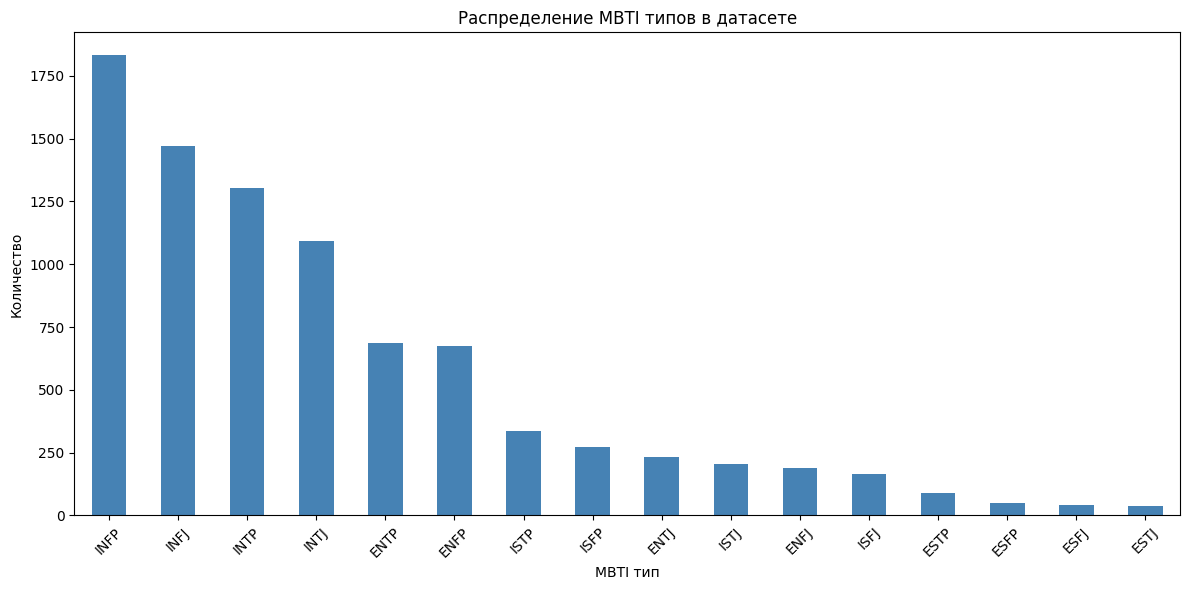


Пример поста (первые 200 символов):
'http://www.youtube.com/watch?v=qsXHcwe3krw|||http://41.media.tumblr.com/tumblr_lfouy03PMA1qa1rooo1_500.jpg|||enfp and intj moments  https://www.youtube.com/watch?v=iz7lE1g4XM4  sportscenter not top t...


In [6]:
import pandas as pd
import matplotlib.pyplot as plt

# Загрузить датасет
df = pd.read_csv('data/raw/mbti_dataset.csv')

print(f"Размер датасета: {df.shape}")
print(f"Колонки: {df.columns.tolist()}")
print(f"\n Распределение MBTI типов:")
type_counts = df['type'].value_counts()
print(type_counts)

# Визуализация
plt.figure(figsize=(12, 6))
type_counts.plot(kind='bar', color='steelblue')
plt.title('Распределение MBTI типов в датасете')
plt.xlabel('MBTI тип')
plt.ylabel('Количество')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print(f"\nПример поста (первые 200 символов):")
print(df['posts'].iloc[0][:200] + "...")


## 6. Обновление репозитория

Подтягиваем свежие изменения из гитхаба командой чтобы синхронизировать код перед дальнейшими шагами.


In [7]:
!git pull

Already up to date.


## 7. Поиск гиперпараметров через Optuna

Вместо ручного подбора параметров используем байесовскую оптимизацию.

Установка через pip install -q optuna optuna-dashboard

In [8]:
# Установка Optuna для поиска гиперпараметров
%pip install -q optuna optuna-dashboard

import optuna
from optuna.trial import Trial
import numpy as np
import json
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

print("✅ Optuna установлен для умного поиска гиперпараметров")


✅ Optuna установлен для умного поиска гиперпараметров


## 8. Импорт модулей
Через import sys


In [9]:
# Импорт модулей проекта
import sys
sys.path.append('/content/MBTI-LSTM')

from src.data.preprocessor import MBTIPostPreprocessor
from src.data.dataset import create_data_loaders
from src.models.lstm_model import LSTMMBTIClassifier
from src.training.trainer import MBTITrainer
from src.training.metrics import MBTIMetrics

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

from google.colab import output
output.enable_custom_widget_manager()

print("✅ Модули проекта импортированы")


✅ Модули проекта импортированы


## 9. Гиперпараметры для поиска
objective() в Optuna

In [ ]:
def objective(trial: Trial) -> float:
    """
    Целевая функция для Optuna.
    Возвращает отрицательную val_accuracy (минимизируем).
    """

    config = {
        'learning_rate': trial.suggest_float('learning_rate', 1e-4, 5e-3, log=True),
        'batch_size': trial.suggest_categorical('batch_size', [16, 32, 64]),
        'hidden_dim_1': trial.suggest_categorical('hidden_dim_1', [64, 128, 256]),
        'hidden_dim_2': trial.suggest_categorical('hidden_dim_2', [32, 64, 128]),
        'dropout': trial.suggest_float('dropout', 0.1, 0.4, step=0.05),
        'optimizer': trial.suggest_categorical('optimizer', ['adam', 'adamw', 'rmsprop']),
        'weight_decay': trial.suggest_float('weight_decay', 0.0, 0.001, step=0.0001),
    }

    print(f"\nTrial {trial.number}: {config['optimizer']}, LR={config['learning_rate']:.4f}, BS={config['batch_size']}")

    try:
        preprocessor = MBTIPostPreprocessor(
            lowercase=True,
            remove_urls=True,
            remove_special_chars=True,
            remove_stopwords=True,
            lemmatize=True
        )

        loaders = create_data_loaders(
            df,
            preprocessor=preprocessor,
            max_length=300,
            batch_size=config['batch_size'],
            val_split=0.15,
            test_split=0.15,
            num_workers=2
        )
        train_loader = loaders['train']
        val_loader = loaders['val']
        vocab = loaders['vocabulary']

        model = LSTMMBTIClassifier(
            vocab_size=len(vocab),
            embedding_dim=200,
            hidden_dim_1=config['hidden_dim_1'],
            hidden_dim_2=config['hidden_dim_2'],
            dropout=config['dropout']
        )

        if config['optimizer'] == 'adam':
            optimizer = torch.optim.Adam(
                model.parameters(),
                lr=config['learning_rate'],
                weight_decay=config['weight_decay']
            )
        elif config['optimizer'] == 'adamw':
            optimizer = torch.optim.AdamW(
                model.parameters(),
                lr=config['learning_rate'],
                weight_decay=config['weight_decay']
            )
        else:
            optimizer = torch.optim.RMSprop(
                model.parameters(),
                lr=config['learning_rate'],
                weight_decay=config['weight_decay']
            )

        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        trainer = MBTITrainer(
            model=model,
            train_loader=train_loader,
            val_loader=val_loader,
            criterion=nn.BCELoss(),
            optimizer=optimizer,
            device=device,
            checkpoint_dir='tmp_optuna',
            save_best_only=False,
            early_stopping_patience=2
        )

        best_val_acc = 0.0
        for epoch in range(1, 6):
            trainer.current_epoch = epoch - 1
            train_metrics = trainer.train_epoch()
            trainer.current_epoch = epoch - 1
            val_metrics = trainer.validate()

            train_loss = train_metrics['loss']
            train_acc = train_metrics['overall_accuracy']
            val_loss = val_metrics['loss']
            val_acc = val_metrics['overall_accuracy']

            print(
                f"    Эпоха {epoch}: train_loss={train_loss:.4f}, train_acc={train_acc:.4f}, "
                f"val_loss={val_loss:.4f}, val_acc={val_acc:.4f}"
            )

            if val_acc > best_val_acc:
                best_val_acc = val_acc

            trial.report(val_acc, epoch)
            if trial.should_prune():
                print(f"  ⚠️ Pruning на эпохе {epoch}")
                raise optuna.TrialPruned()

        print(f"  ✅ Лучшая val_acc: {best_val_acc:.4f}")
        return -best_val_acc

    except Exception as e:
        print(f"  ❌ Ошибка: {e}")
        return 0.0



## 10. Optuna study
Через study = optuna.create_study()


In [11]:
# Создаём Optuna study
study = optuna.create_study(
    study_name='mbti_lstm_hp_search',
    direction='minimize',
    pruner=optuna.pruners.MedianPruner(
        n_startup_trials=3,
        n_warmup_steps=2,
        interval_steps=1
    )
)

print("="*60)
print("ПОИСК ГИПЕРПАРАМЕТРОВ ЧЕРЕЗ OPTUNA")
print("="*60)
print("Количество попыток: 15 ")
print("Эпох на попытку: 5")
print("Время: ~30-40 минут")
print("="*60)


[I 2025-10-08 16:19:15,718] A new study created in memory with name: mbti_lstm_hp_search


ПОИСК ГИПЕРПАРАМЕТРОВ ЧЕРЕЗ OPTUNA
Количество попыток: 15 
Эпох на попытку: 5
Время: ~30-40 минут


## 11. Оптимизация
Через study.optimize()


In [12]:
# Запуск оптимизации
study.optimize(
    objective,
    n_trials=15,
    gc_after_trial=True,
    show_progress_bar=True
)


  0%|          | 0/15 [00:00<?, ?it/s]


Trial 0: adamw, LR=0.0026, BS=32
Размеры выборок - Train: 6071, Val: 1302, Test: 1302
Предобработка текстов...
Построение словаря...
Размер словаря: 38440
Датасет инициализирован: 6071 сэмплов
Предобработка текстов...
Датасет инициализирован: 1302 сэмплов
Предобработка текстов...
Датасет инициализирован: 1302 сэмплов
Балансировка обучающих данных...
Тренер инициализирован на устройстве: cuda
В модели 8,437,892 параметров



Эпоха 1 [Обучение]: 100%|██████████| 190/190 [00:12<00:00, 15.30it/s, loss=0.5774, lr=0.002641]
                                                                                               
Эпоха 1 [Валидация]:  93%|█████████▎| 38/41 [00:01<00:00, 44.38it/s, loss=0.6760]
                                                                                 

    Эпоха 1: train_loss=0.5723, train_acc=0.6716, val_loss=0.6760, val_acc=0.6125



Эпоха 1 [Обучение]:  99%|█████████▉| 189/190 [00:09<00:00, 21.54it/s, loss=0.4051, lr=0.002641]
                                                                                               
Эпоха 1 [Валидация]:  93%|█████████▎| 38/41 [00:01<00:00, 34.06it/s, loss=0.7255]
                                                                                 

    Эпоха 2: train_loss=0.4028, train_acc=0.8003, val_loss=0.7255, val_acc=0.6269



Эпоха 1 [Обучение]:  99%|█████████▉| 188/190 [00:09<00:00, 21.23it/s, loss=0.2994, lr=0.002641]
                                                                                               
Эпоха 1 [Валидация]:  88%|████████▊ | 36/41 [00:01<00:00, 42.15it/s, loss=0.8037]
                                                                                 

    Эпоха 3: train_loss=0.2974, train_acc=0.8626, val_loss=0.8037, val_acc=0.6064



Эпоха 1 [Обучение]:  99%|█████████▉| 188/190 [00:09<00:00, 21.43it/s, loss=0.2482, lr=0.002641]
                                                                                               
Эпоха 1 [Валидация]:  98%|█████████▊| 40/41 [00:01<00:00, 45.24it/s, loss=0.7718]
                                                                                 

    Эпоха 4: train_loss=0.2455, train_acc=0.8916, val_loss=0.7718, val_acc=0.6404



Эпоха 1 [Обучение]:  99%|█████████▉| 189/190 [00:10<00:00, 22.17it/s, loss=0.2071, lr=0.002641]
                                                                                               
Эпоха 1 [Валидация]:  98%|█████████▊| 40/41 [00:01<00:00, 44.33it/s, loss=0.8019]
                                                                                 

    Эпоха 5: train_loss=0.2079, train_acc=0.9081, val_loss=0.8019, val_acc=0.6333
  ✅ Лучшая val_acc: 0.6404
[I 2025-10-08 16:21:26,015] Trial 0 finished with value: -0.6403609831029186 and parameters: {'learning_rate': 0.0026413596609548957, 'batch_size': 32, 'hidden_dim_1': 128, 'hidden_dim_2': 128, 'dropout': 0.25, 'optimizer': 'adamw', 'weight_decay': 0.0}. Best is trial 0 with value: -0.6403609831029186.

Trial 1: adamw, LR=0.0022, BS=16
Размеры выборок - Train: 6071, Val: 1302, Test: 1302
Предобработка текстов...
Построение словаря...
Размер словаря: 38440
Датасет инициализирован: 6071 сэмплов
Предобработка текстов...
Датасет инициализирован: 1302 сэмплов
Предобработка текстов...
Датасет инициализирован: 1302 сэмплов
Балансировка обучающих данных...
Тренер инициализирован на устройстве: cuda
В модели 7,932,036 параметров



Эпоха 1 [Обучение]:  99%|█████████▉| 378/380 [00:18<00:00, 22.35it/s, loss=0.5711, lr=0.002246]
                                                                                               
Эпоха 1 [Валидация]:  99%|█████████▉| 81/82 [00:02<00:00, 37.61it/s, loss=0.6845]
                                                                                 

    Эпоха 1: train_loss=0.5691, train_acc=0.6720, val_loss=0.6845, val_acc=0.6208



Эпоха 1 [Обучение]: 100%|█████████▉| 379/380 [00:18<00:00, 21.90it/s, loss=0.3895, lr=0.002246]
                                                                                               
Эпоха 1 [Валидация]:  96%|█████████▋| 79/82 [00:02<00:00, 42.53it/s, loss=0.6960]
                                                                                 

    Эпоха 2: train_loss=0.3901, train_acc=0.8071, val_loss=0.6960, val_acc=0.6392



Эпоха 1 [Обучение]:  99%|█████████▉| 378/380 [00:18<00:00, 22.43it/s, loss=0.2972, lr=0.002246]
                                                                                               
Эпоха 1 [Валидация]: 100%|██████████| 82/82 [00:02<00:00, 39.74it/s, loss=0.7403]
                                                                                 

    Эпоха 3: train_loss=0.2966, train_acc=0.8621, val_loss=0.7403, val_acc=0.6432



Эпоха 1 [Обучение]: 100%|██████████| 380/380 [00:18<00:00, 22.88it/s, loss=0.2388, lr=0.002246]
                                                                                               
Эпоха 1 [Валидация]:  99%|█████████▉| 81/82 [00:02<00:00, 40.40it/s, loss=0.8170]
                                                                                 

    Эпоха 4: train_loss=0.2374, train_acc=0.8941, val_loss=0.8170, val_acc=0.6377



Эпоха 1 [Обучение]:  99%|█████████▉| 378/380 [00:18<00:00, 22.75it/s, loss=0.2114, lr=0.002246]
                                                                                               
Эпоха 1 [Валидация]:  98%|█████████▊| 80/82 [00:02<00:00, 39.00it/s, loss=0.8331]
                                                                                 

    Эпоха 5: train_loss=0.2121, train_acc=0.9077, val_loss=0.8331, val_acc=0.6396
  ✅ Лучшая val_acc: 0.6432
[I 2025-10-08 16:24:08,814] Trial 1 finished with value: -0.6432411674347159 and parameters: {'learning_rate': 0.002246348624418691, 'batch_size': 16, 'hidden_dim_1': 64, 'hidden_dim_2': 64, 'dropout': 0.2, 'optimizer': 'adamw', 'weight_decay': 0.0006000000000000001}. Best is trial 1 with value: -0.6432411674347159.

Trial 2: adam, LR=0.0028, BS=32
Размеры выборок - Train: 6071, Val: 1302, Test: 1302
Предобработка текстов...
Построение словаря...
Размер словаря: 38440
Датасет инициализирован: 6071 сэмплов
Предобработка текстов...
Датасет инициализирован: 1302 сэмплов
Предобработка текстов...
Датасет инициализирован: 1302 сэмплов
Балансировка обучающих данных...
Тренер инициализирован на устройстве: cuda
В модели 8,930,436 параметров



Эпоха 1 [Обучение]:  99%|█████████▉| 189/190 [00:11<00:00, 18.57it/s, loss=0.6439, lr=0.002810]
                                                                                               
Эпоха 1 [Валидация]:  98%|█████████▊| 40/41 [00:01<00:00, 35.77it/s, loss=0.6507]
                                                                                 

    Эпоха 1: train_loss=0.6415, train_acc=0.6052, val_loss=0.6507, val_acc=0.6189



Эпоха 1 [Обучение]:  99%|█████████▉| 188/190 [00:11<00:00, 18.08it/s, loss=0.5669, lr=0.002810]
                                                                                               
Эпоха 1 [Валидация]: 100%|██████████| 41/41 [00:01<00:00, 36.74it/s, loss=0.6444]
                                                                                 

    Эпоха 2: train_loss=0.5651, train_acc=0.6809, val_loss=0.6444, val_acc=0.6302



Эпоха 1 [Обучение]: 100%|██████████| 190/190 [00:11<00:00, 19.32it/s, loss=0.5232, lr=0.002810]
                                                                                               
Эпоха 1 [Валидация]:  98%|█████████▊| 40/41 [00:01<00:00, 37.20it/s, loss=0.6635]
                                                                                 

    Эпоха 3: train_loss=0.5215, train_acc=0.7121, val_loss=0.6635, val_acc=0.5887



Эпоха 1 [Обучение]: 100%|██████████| 190/190 [00:11<00:00, 19.66it/s, loss=0.4690, lr=0.002810]
                                                                                               
Эпоха 1 [Валидация]: 100%|██████████| 41/41 [00:01<00:00, 33.82it/s, loss=0.6273]
                                                                                 

    Эпоха 4: train_loss=0.4696, train_acc=0.7498, val_loss=0.6273, val_acc=0.6482



Эпоха 1 [Обучение]:  99%|█████████▉| 189/190 [00:11<00:00, 18.43it/s, loss=0.4289, lr=0.002810]
                                                                                               
Эпоха 1 [Валидация]: 100%|██████████| 41/41 [00:01<00:00, 35.80it/s, loss=0.6346]
                                                                                 

    Эпоха 5: train_loss=0.4278, train_acc=0.7859, val_loss=0.6346, val_acc=0.6513
  ✅ Лучшая val_acc: 0.6513
[I 2025-10-08 16:26:10,520] Trial 2 finished with value: -0.6513056835637481 and parameters: {'learning_rate': 0.002810483731421554, 'batch_size': 32, 'hidden_dim_1': 256, 'hidden_dim_2': 64, 'dropout': 0.4, 'optimizer': 'adam', 'weight_decay': 0.0002}. Best is trial 2 with value: -0.6513056835637481.

Trial 3: adamw, LR=0.0004, BS=32
Размеры выборок - Train: 6071, Val: 1302, Test: 1302
Предобработка текстов...
Построение словаря...
Размер словаря: 38440
Датасет инициализирован: 6071 сэмплов
Предобработка текстов...
Датасет инициализирован: 1302 сэмплов
Предобработка текстов...
Датасет инициализирован: 1302 сэмплов
Балансировка обучающих данных...
Тренер инициализирован на устройстве: cuda
В модели 7,932,036 параметров



Эпоха 1 [Обучение]: 100%|██████████| 190/190 [00:10<00:00, 21.05it/s, loss=0.6869, lr=0.000409]
                                                                                               
Эпоха 1 [Валидация]:  90%|█████████ | 37/41 [00:01<00:00, 31.18it/s, loss=0.6928]
                                                                                 

    Эпоха 1: train_loss=0.6865, train_acc=0.5546, val_loss=0.6928, val_acc=0.5194



Эпоха 1 [Обучение]:  99%|█████████▉| 188/190 [00:10<00:00, 20.13it/s, loss=0.6205, lr=0.000409]
                                                                                               
Эпоха 1 [Валидация]:  90%|█████████ | 37/41 [00:01<00:00, 31.01it/s, loss=0.6580]
                                                                                 

    Эпоха 2: train_loss=0.6180, train_acc=0.6605, val_loss=0.6580, val_acc=0.6325



Эпоха 1 [Обучение]: 100%|██████████| 190/190 [00:11<00:00, 20.59it/s, loss=0.5165, lr=0.000409]
                                                                                               
Эпоха 1 [Валидация]:  98%|█████████▊| 40/41 [00:01<00:00, 32.95it/s, loss=0.6714]
                                                                                 

    Эпоха 3: train_loss=0.5158, train_acc=0.7288, val_loss=0.6714, val_acc=0.6367



Эпоха 1 [Обучение]:  99%|█████████▉| 189/190 [00:11<00:00, 20.11it/s, loss=0.4649, lr=0.000409]
                                                                                               
Эпоха 1 [Валидация]:  90%|█████████ | 37/41 [00:01<00:00, 34.49it/s, loss=0.6592]
                                                                                 

    Эпоха 4: train_loss=0.4629, train_acc=0.7620, val_loss=0.6592, val_acc=0.6427



Эпоха 1 [Обучение]:  99%|█████████▉| 189/190 [00:11<00:00, 17.40it/s, loss=0.4114, lr=0.000409]
                                                                                               
Эпоха 1 [Валидация]: 100%|██████████| 41/41 [00:01<00:00, 34.00it/s, loss=0.6948]
                                                                                 

    Эпоха 5: train_loss=0.4100, train_acc=0.8032, val_loss=0.6948, val_acc=0.6304
  ✅ Лучшая val_acc: 0.6427
[I 2025-10-08 16:28:13,254] Trial 3 finished with value: -0.6426651305683564 and parameters: {'learning_rate': 0.0004091614300417707, 'batch_size': 32, 'hidden_dim_1': 64, 'hidden_dim_2': 64, 'dropout': 0.25, 'optimizer': 'adamw', 'weight_decay': 0.0004}. Best is trial 2 with value: -0.6513056835637481.

Trial 4: adam, LR=0.0001, BS=64
Размеры выборок - Train: 6071, Val: 1302, Test: 1302
Предобработка текстов...
Построение словаря...
Размер словаря: 38440
Датасет инициализирован: 6071 сэмплов
Предобработка текстов...
Датасет инициализирован: 1302 сэмплов
Предобработка текстов...
Датасет инициализирован: 1302 сэмплов
Балансировка обучающих данных...
Тренер инициализирован на устройстве: cuda
В модели 7,932,036 параметров



Эпоха 1 [Обучение]: 100%|██████████| 95/95 [00:05<00:00, 18.29it/s, loss=0.6930, lr=0.000131]
                                                                                             
Эпоха 1 [Валидация]: 100%|██████████| 21/21 [00:00<00:00, 30.19it/s, loss=0.6914]
                                                                                 

    Эпоха 1: train_loss=0.6929, train_acc=0.5096, val_loss=0.6914, val_acc=0.5378



Эпоха 1 [Обучение]:  98%|█████████▊| 93/95 [00:06<00:00, 17.31it/s, loss=0.6913, lr=0.000131]
                                                                                             
Эпоха 1 [Валидация]:  81%|████████  | 17/21 [00:00<00:00, 27.09it/s, loss=0.6914]
                                                                                 

    Эпоха 2: train_loss=0.6914, train_acc=0.5277, val_loss=0.6914, val_acc=0.5386



Эпоха 1 [Обучение]:  98%|█████████▊| 93/95 [00:05<00:00, 18.17it/s, loss=0.6901, lr=0.000131]
                                                                                             
Эпоха 1 [Валидация]: 100%|██████████| 21/21 [00:00<00:00, 30.01it/s, loss=0.6921]
                                                                                 

    Эпоха 3: train_loss=0.6900, train_acc=0.5470, val_loss=0.6921, val_acc=0.5313



Эпоха 1 [Обучение]:  98%|█████████▊| 93/95 [00:06<00:00, 18.54it/s, loss=0.6889, lr=0.000131]
                                                                                             
Эпоха 1 [Валидация]:  86%|████████▌ | 18/21 [00:00<00:00, 27.36it/s, loss=0.6921]
                                                                                 

    Эпоха 4: train_loss=0.6890, train_acc=0.5595, val_loss=0.6921, val_acc=0.5303



Эпоха 1 [Обучение]:  98%|█████████▊| 93/95 [00:05<00:00, 17.50it/s, loss=0.6871, lr=0.000131]
                                                                                             
Эпоха 1 [Валидация]: 100%|██████████| 21/21 [00:01<00:00, 27.28it/s, loss=0.6927]
                                                                                 

    Эпоха 5: train_loss=0.6871, train_acc=0.5787, val_loss=0.6927, val_acc=0.5244
  ✅ Лучшая val_acc: 0.5386
[I 2025-10-08 16:29:47,448] Trial 4 finished with value: -0.538594470046083 and parameters: {'learning_rate': 0.00013063111228573882, 'batch_size': 64, 'hidden_dim_1': 64, 'hidden_dim_2': 64, 'dropout': 0.25, 'optimizer': 'adam', 'weight_decay': 0.001}. Best is trial 2 with value: -0.6513056835637481.

Trial 5: adam, LR=0.0002, BS=16
Размеры выборок - Train: 6071, Val: 1302, Test: 1302
Предобработка текстов...
Построение словаря...
Размер словаря: 38440
Датасет инициализирован: 6071 сэмплов
Предобработка текстов...
Датасет инициализирован: 1302 сэмплов
Предобработка текстов...
Датасет инициализирован: 1302 сэмплов
Балансировка обучающих данных...
Тренер инициализирован на устройстве: cuda
В модели 8,930,436 параметров



Эпоха 1 [Обучение]:  99%|█████████▉| 378/380 [00:22<00:00, 18.81it/s, loss=0.6756, lr=0.000166]
                                                                                               
Эпоха 1 [Валидация]:  95%|█████████▌| 78/82 [00:02<00:00, 38.43it/s, loss=0.6738]
                                                                                 

    Эпоха 1: train_loss=0.6751, train_acc=0.6012, val_loss=0.6738, val_acc=0.5883



Эпоха 1 [Обучение]: 100%|█████████▉| 379/380 [00:22<00:00, 19.71it/s, loss=0.5715, lr=0.000166]
                                                                                               
Эпоха 1 [Валидация]:  95%|█████████▌| 78/82 [00:02<00:00, 36.65it/s, loss=0.6810]
                                                                                 

    Эпоха 2: train_loss=0.5703, train_acc=0.6989, val_loss=0.6810, val_acc=0.6133



Эпоха 1 [Обучение]: 100%|█████████▉| 379/380 [00:23<00:00, 19.33it/s, loss=0.4689, lr=0.000166]
                                                                                               
Эпоха 1 [Валидация]: 100%|██████████| 82/82 [00:02<00:00, 40.46it/s, loss=0.7037]
                                                                                 

    Эпоха 3: train_loss=0.4679, train_acc=0.7680, val_loss=0.7037, val_acc=0.6133



Эпоха 1 [Обучение]: 100%|█████████▉| 379/380 [00:22<00:00, 19.54it/s, loss=0.4143, lr=0.000166]
                                                                                               
Эпоха 1 [Валидация]:  96%|█████████▋| 79/82 [00:02<00:00, 38.63it/s, loss=0.7323]
                                                                                 

    Эпоха 4: train_loss=0.4131, train_acc=0.8049, val_loss=0.7323, val_acc=0.6023



Эпоха 1 [Обучение]: 100%|█████████▉| 379/380 [00:23<00:00, 18.85it/s, loss=0.3618, lr=0.000166]
                                                                                               
Эпоха 1 [Валидация]:  95%|█████████▌| 78/82 [00:02<00:00, 38.94it/s, loss=0.7173]
                                                                                 

    Эпоха 5: train_loss=0.3622, train_acc=0.8337, val_loss=0.7173, val_acc=0.6246
  ✅ Лучшая val_acc: 0.6246
[I 2025-10-08 16:32:53,697] Trial 5 finished with value: -0.6246159754224271 and parameters: {'learning_rate': 0.00016631935214386865, 'batch_size': 16, 'hidden_dim_1': 256, 'hidden_dim_2': 64, 'dropout': 0.15000000000000002, 'optimizer': 'adam', 'weight_decay': 0.0001}. Best is trial 2 with value: -0.6513056835637481.

Trial 6: adam, LR=0.0002, BS=16
Размеры выборок - Train: 6071, Val: 1302, Test: 1302
Предобработка текстов...
Построение словаря...
Размер словаря: 38440
Датасет инициализирован: 6071 сэмплов
Предобработка текстов...
Датасет инициализирован: 1302 сэмплов
Предобработка текстов...
Датасет инициализирован: 1302 сэмплов
Балансировка обучающих данных...
Тренер инициализирован на устройстве: cuda
В модели 8,437,892 параметров



Эпоха 1 [Обучение]: 100%|█████████▉| 379/380 [00:23<00:00, 17.25it/s, loss=0.6833, lr=0.000156]
                                                                                               
Эпоха 1 [Валидация]:  96%|█████████▋| 79/82 [00:02<00:00, 38.96it/s, loss=0.6843]
                                                                                 

    Эпоха 1: train_loss=0.6829, train_acc=0.5827, val_loss=0.6843, val_acc=0.5741



Эпоха 1 [Обучение]: 100%|█████████▉| 379/380 [00:24<00:00, 18.42it/s, loss=0.6147, lr=0.000156]
                                                                                               
Эпоха 1 [Валидация]: 100%|██████████| 82/82 [00:02<00:00, 40.27it/s, loss=0.6841]
                                                                                 

    Эпоха 2: train_loss=0.6131, train_acc=0.6752, val_loss=0.6841, val_acc=0.5977



Эпоха 1 [Обучение]: 100%|█████████▉| 379/380 [00:24<00:00, 17.55it/s, loss=0.5203, lr=0.000156]
                                                                                               
Эпоха 1 [Валидация]:  98%|█████████▊| 80/82 [00:02<00:00, 40.16it/s, loss=0.6927]
                                                                                 

    Эпоха 3: train_loss=0.5195, train_acc=0.7312, val_loss=0.6927, val_acc=0.6173



Эпоха 1 [Обучение]: 100%|█████████▉| 379/380 [00:24<00:00, 17.45it/s, loss=0.4505, lr=0.000156]
                                                                                               
Эпоха 1 [Валидация]:  96%|█████████▋| 79/82 [00:02<00:00, 39.74it/s, loss=0.7328]
                                                                                 

    Эпоха 4: train_loss=0.4504, train_acc=0.7805, val_loss=0.7328, val_acc=0.6102



Эпоха 1 [Обучение]: 100%|█████████▉| 379/380 [00:25<00:00, 16.59it/s, loss=0.4065, lr=0.000156]
                                                                                               
Эпоха 1 [Валидация]: 100%|██████████| 82/82 [00:02<00:00, 40.36it/s, loss=0.7377]
                                                                                 

    Эпоха 5: train_loss=0.4055, train_acc=0.8105, val_loss=0.7377, val_acc=0.6141
  ✅ Лучшая val_acc: 0.6173
[I 2025-10-08 16:36:08,389] Trial 6 finished with value: -0.6173195084485408 and parameters: {'learning_rate': 0.00015645985087031067, 'batch_size': 16, 'hidden_dim_1': 128, 'hidden_dim_2': 128, 'dropout': 0.1, 'optimizer': 'adam', 'weight_decay': 0.00030000000000000003}. Best is trial 2 with value: -0.6513056835637481.

Trial 7: rmsprop, LR=0.0046, BS=64
Размеры выборок - Train: 6071, Val: 1302, Test: 1302
Предобработка текстов...
Построение словаря...
Размер словаря: 38440
Датасет инициализирован: 6071 сэмплов
Предобработка текстов...
Датасет инициализирован: 1302 сэмплов
Предобработка текстов...
Датасет инициализирован: 1302 сэмплов
Балансировка обучающих данных...
Тренер инициализирован на устройстве: cuda
В модели 8,199,300 параметров



Эпоха 1 [Обучение]:  99%|█████████▉| 94/95 [00:06<00:00, 17.00it/s, loss=0.6689, lr=0.004586]
                                                                                             
Эпоха 1 [Валидация]: 100%|██████████| 21/21 [00:00<00:00, 28.44it/s, loss=0.6513]
                                                                                 

    Эпоха 1: train_loss=0.6682, train_acc=0.5859, val_loss=0.6513, val_acc=0.6123



Эпоха 1 [Обучение]: 100%|██████████| 95/95 [00:07<00:00, 14.74it/s, loss=0.6083, lr=0.004586]
                                                                                             
Эпоха 1 [Валидация]:  95%|█████████▌| 20/21 [00:01<00:00, 26.73it/s, loss=0.6456]
                                                                                 

    Эпоха 2: train_loss=0.6072, train_acc=0.6477, val_loss=0.6456, val_acc=0.6465



Эпоха 1 [Обучение]: 100%|██████████| 95/95 [00:08<00:00, 16.43it/s, loss=0.5596, lr=0.004586]
                                                                                             
Эпоха 1 [Валидация]:  90%|█████████ | 19/21 [00:00<00:00, 28.47it/s, loss=0.6279]
                                                                                 

    Эпоха 3: train_loss=0.5581, train_acc=0.6895, val_loss=0.6279, val_acc=0.6425



Эпоха 1 [Обучение]: 100%|██████████| 95/95 [00:06<00:00, 16.53it/s, loss=0.5192, lr=0.004586]
                                                                                             
Эпоха 1 [Валидация]: 100%|██████████| 21/21 [00:00<00:00, 32.67it/s, loss=0.6262]
                                                                                 

    Эпоха 4: train_loss=0.5180, train_acc=0.7176, val_loss=0.6262, val_acc=0.6482



Эпоха 1 [Обучение]: 100%|██████████| 95/95 [00:07<00:00, 16.43it/s, loss=0.4802, lr=0.004586]
                                                                                             
Эпоха 1 [Валидация]: 100%|██████████| 21/21 [00:00<00:00, 31.51it/s, loss=0.6822]
                                                                                 

    Эпоха 5: train_loss=0.4800, train_acc=0.7482, val_loss=0.6822, val_acc=0.5854
  ✅ Лучшая val_acc: 0.6482
[I 2025-10-08 16:37:50,838] Trial 7 finished with value: -0.6482334869431644 and parameters: {'learning_rate': 0.004585936496447972, 'batch_size': 64, 'hidden_dim_1': 128, 'hidden_dim_2': 64, 'dropout': 0.25, 'optimizer': 'rmsprop', 'weight_decay': 0.0006000000000000001}. Best is trial 2 with value: -0.6513056835637481.

Trial 8: adamw, LR=0.0009, BS=32
Размеры выборок - Train: 6071, Val: 1302, Test: 1302
Предобработка текстов...
Построение словаря...
Размер словаря: 38440
Датасет инициализирован: 6071 сэмплов
Предобработка текстов...
Датасет инициализирован: 1302 сэмплов
Предобработка текстов...
Датасет инициализирован: 1302 сэмплов
Балансировка обучающих данных...
Тренер инициализирован на устройстве: cuda
В модели 7,870,084 параметров



Эпоха 1 [Обучение]:  99%|█████████▉| 189/190 [00:12<00:00, 16.52it/s, loss=0.6470, lr=0.000903]
                                                                                               
Эпоха 1 [Валидация]: 100%|██████████| 41/41 [00:01<00:00, 35.91it/s, loss=0.6799]
                                                                                 

    Эпоха 1: train_loss=0.6424, train_acc=0.6145, val_loss=0.6799, val_acc=0.6012



Эпоха 1 [Обучение]: 100%|██████████| 190/190 [00:12<00:00, 19.00it/s, loss=0.4714, lr=0.000903]
                                                                                               
Эпоха 1 [Валидация]: 100%|██████████| 41/41 [00:01<00:00, 36.75it/s, loss=0.6839]
                                                                                 

    Эпоха 2: train_loss=0.4684, train_acc=0.7620, val_loss=0.6839, val_acc=0.6237



Эпоха 1 [Обучение]: 100%|██████████| 190/190 [00:12<00:00, 18.86it/s, loss=0.3642, lr=0.000903]
                                                                                               
Эпоха 1 [Валидация]:  90%|█████████ | 37/41 [00:01<00:00, 34.61it/s, loss=0.6999]
                                                                                 

    Эпоха 3: train_loss=0.3632, train_acc=0.8301, val_loss=0.6999, val_acc=0.6275



Эпоха 1 [Обучение]:  99%|█████████▉| 189/190 [00:13<00:00, 18.22it/s, loss=0.2816, lr=0.000903]
                                                                                               
Эпоха 1 [Валидация]: 100%|██████████| 41/41 [00:01<00:00, 36.09it/s, loss=0.7620]
                                                                                 

    Эпоха 4: train_loss=0.2817, train_acc=0.8745, val_loss=0.7620, val_acc=0.6317



Эпоха 1 [Обучение]:  99%|█████████▉| 189/190 [00:13<00:00, 17.98it/s, loss=0.2335, lr=0.000903]
                                                                                               
Эпоха 1 [Валидация]:  95%|█████████▌| 39/41 [00:01<00:00, 33.79it/s, loss=0.7887]
                                                                                 

    Эпоха 5: train_loss=0.2340, train_acc=0.8986, val_loss=0.7887, val_acc=0.6459
  ✅ Лучшая val_acc: 0.6459
[I 2025-10-08 16:40:00,711] Trial 8 finished with value: -0.6459293394777266 and parameters: {'learning_rate': 0.0009034976577641392, 'batch_size': 32, 'hidden_dim_1': 64, 'hidden_dim_2': 32, 'dropout': 0.15000000000000002, 'optimizer': 'adamw', 'weight_decay': 0.00030000000000000003}. Best is trial 2 with value: -0.6513056835637481.

Trial 9: adamw, LR=0.0018, BS=16
Размеры выборок - Train: 6071, Val: 1302, Test: 1302
Предобработка текстов...
Построение словаря...
Размер словаря: 38440
Датасет инициализирован: 6071 сэмплов
Предобработка текстов...
Датасет инициализирован: 1302 сэмплов
Предобработка текстов...
Датасет инициализирован: 1302 сэмплов
Балансировка обучающих данных...
Тренер инициализирован на устройстве: cuda
В модели 7,870,084 параметров



Эпоха 1 [Обучение]: 100%|██████████| 380/380 [00:23<00:00, 18.18it/s, loss=0.5557, lr=0.001757]
                                                                                               
Эпоха 1 [Валидация]:  99%|█████████▉| 81/82 [00:02<00:00, 37.81it/s, loss=0.6915]
                                                                                 

    Эпоха 1: train_loss=0.5529, train_acc=0.6882, val_loss=0.6915, val_acc=0.6064



Эпоха 1 [Обучение]: 100%|█████████▉| 379/380 [00:25<00:00, 15.51it/s, loss=0.3616, lr=0.001757]
                                                                                               
Эпоха 1 [Валидация]:  99%|█████████▉| 81/82 [00:02<00:00, 34.87it/s, loss=0.7166]
                                                                                 

    Эпоха 2: train_loss=0.3614, train_acc=0.8268, val_loss=0.7166, val_acc=0.6256



Эпоха 1 [Обучение]: 100%|█████████▉| 379/380 [00:26<00:00, 16.15it/s, loss=0.2700, lr=0.001757]
                                                                                               
Эпоха 1 [Валидация]: 100%|██████████| 82/82 [00:02<00:00, 39.04it/s, loss=0.7298]
                                                                                 

    Эпоха 3: train_loss=0.2694, train_acc=0.8786, val_loss=0.7298, val_acc=0.6461



Эпоха 1 [Обучение]: 100%|█████████▉| 379/380 [00:26<00:00, 16.91it/s, loss=0.2174, lr=0.001757]
                                                                                               
Эпоха 1 [Валидация]:  99%|█████████▉| 81/82 [00:02<00:00, 38.71it/s, loss=0.7963]
                                                                                 

    Эпоха 4: train_loss=0.2174, train_acc=0.9025, val_loss=0.7963, val_acc=0.6525



Эпоха 1 [Обучение]: 100%|█████████▉| 379/380 [00:26<00:00, 16.82it/s, loss=0.1830, lr=0.001757]
                                                                                               
Эпоха 1 [Валидация]: 100%|██████████| 82/82 [00:02<00:00, 39.31it/s, loss=0.8367]
                                                                                 

    Эпоха 5: train_loss=0.1824, train_acc=0.9216, val_loss=0.8367, val_acc=0.6498
  ✅ Лучшая val_acc: 0.6525
[I 2025-10-08 16:43:22,049] Trial 9 finished with value: -0.6524577572964669 and parameters: {'learning_rate': 0.0017571371277079488, 'batch_size': 16, 'hidden_dim_1': 64, 'hidden_dim_2': 32, 'dropout': 0.15000000000000002, 'optimizer': 'adamw', 'weight_decay': 0.0007}. Best is trial 9 with value: -0.6524577572964669.

Trial 10: rmsprop, LR=0.0009, BS=16
Размеры выборок - Train: 6071, Val: 1302, Test: 1302
Предобработка текстов...
Построение словаря...
Размер словаря: 38440
Датасет инициализирован: 6071 сэмплов
Предобработка текстов...
Датасет инициализирован: 1302 сэмплов
Предобработка текстов...
Датасет инициализирован: 1302 сэмплов
Балансировка обучающих данных...
Тренер инициализирован на устройстве: cuda
В модели 7,870,084 параметров



Эпоха 1 [Обучение]: 100%|█████████▉| 379/380 [00:23<00:00, 13.62it/s, loss=0.6760, lr=0.000886]
                                                                                               
Эпоха 1 [Валидация]:  99%|█████████▉| 81/82 [00:02<00:00, 37.88it/s, loss=0.6724]
                                                                                 

    Эпоха 1: train_loss=0.6755, train_acc=0.5742, val_loss=0.6724, val_acc=0.5998



Эпоха 1 [Обучение]: 100%|██████████| 380/380 [00:25<00:00, 16.67it/s, loss=0.6336, lr=0.000886]
                                                                                               
Эпоха 1 [Валидация]:  95%|█████████▌| 78/82 [00:02<00:00, 36.89it/s, loss=0.6704]
                                                                                 

    Эпоха 2: train_loss=0.6326, train_acc=0.6255, val_loss=0.6704, val_acc=0.6031



Эпоха 1 [Обучение]: 100%|█████████▉| 379/380 [00:25<00:00, 15.68it/s, loss=0.6070, lr=0.000886]
                                                                                               
Эпоха 1 [Валидация]:  95%|█████████▌| 78/82 [00:02<00:00, 38.35it/s, loss=0.6577]
                                                                                 

    Эпоха 3: train_loss=0.6067, train_acc=0.6541, val_loss=0.6577, val_acc=0.6183



Эпоха 1 [Обучение]: 100%|█████████▉| 379/380 [00:25<00:00, 16.61it/s, loss=0.5836, lr=0.000886]
                                                                                               
Эпоха 1 [Валидация]: 100%|██████████| 82/82 [00:02<00:00, 39.61it/s, loss=0.6761]
                                                                                 

    Эпоха 4: train_loss=0.5833, train_acc=0.6667, val_loss=0.6761, val_acc=0.6073



Эпоха 1 [Обучение]: 100%|██████████| 380/380 [00:26<00:00, 16.14it/s, loss=0.5607, lr=0.000886]
                                                                                               
Эпоха 1 [Валидация]: 100%|██████████| 82/82 [00:02<00:00, 37.24it/s, loss=0.6694]
                                                                                 

    Эпоха 5: train_loss=0.5605, train_acc=0.6844, val_loss=0.6694, val_acc=0.6039
  ✅ Лучшая val_acc: 0.6183
[I 2025-10-08 16:46:45,190] Trial 10 finished with value: -0.6182795698924731 and parameters: {'learning_rate': 0.0008859146625634027, 'batch_size': 16, 'hidden_dim_1': 64, 'hidden_dim_2': 32, 'dropout': 0.35, 'optimizer': 'rmsprop', 'weight_decay': 0.0009000000000000001}. Best is trial 9 with value: -0.6524577572964669.

Trial 11: adam, LR=0.0019, BS=32
Размеры выборок - Train: 6071, Val: 1302, Test: 1302
Предобработка текстов...
Построение словаря...
Размер словаря: 38440
Датасет инициализирован: 6071 сэмплов
Предобработка текстов...
Датасет инициализирован: 1302 сэмплов
Предобработка текстов...
Датасет инициализирован: 1302 сэмплов
Балансировка обучающих данных...
Тренер инициализирован на устройстве: cuda
В модели 8,770,180 параметров



Эпоха 1 [Обучение]: 100%|██████████| 190/190 [00:14<00:00, 16.16it/s, loss=0.6674, lr=0.001851]
                                                                                               
Эпоха 1 [Валидация]:  98%|█████████▊| 40/41 [00:01<00:00, 29.84it/s, loss=0.6547]
                                                                                 

    Эпоха 1: train_loss=0.6665, train_acc=0.5848, val_loss=0.6547, val_acc=0.6392



Эпоха 1 [Обучение]:  99%|█████████▉| 189/190 [00:14<00:00, 13.34it/s, loss=0.6340, lr=0.001851]
                                                                                               
Эпоха 1 [Валидация]:  95%|█████████▌| 39/41 [00:01<00:00, 28.56it/s, loss=0.6675]
                                                                                 

    Эпоха 2: train_loss=0.6333, train_acc=0.6278, val_loss=0.6675, val_acc=0.6373
  ⚠️ Pruning на эпохе 2
  ❌ Ошибка: 
[I 2025-10-08 16:48:28,516] Trial 11 finished with value: 0.0 and parameters: {'learning_rate': 0.0018512274698890686, 'batch_size': 32, 'hidden_dim_1': 256, 'hidden_dim_2': 32, 'dropout': 0.4, 'optimizer': 'adam', 'weight_decay': 0.0008}. Best is trial 9 with value: -0.6524577572964669.

Trial 12: adamw, LR=0.0047, BS=16
Размеры выборок - Train: 6071, Val: 1302, Test: 1302
Предобработка текстов...
Построение словаря...
Размер словаря: 38440
Датасет инициализирован: 6071 сэмплов
Предобработка текстов...
Датасет инициализирован: 1302 сэмплов
Предобработка текстов...
Датасет инициализирован: 1302 сэмплов
Балансировка обучающих данных...
Тренер инициализирован на устройстве: cuda
В модели 8,770,180 параметров



Эпоха 1 [Обучение]: 100%|█████████▉| 379/380 [00:25<00:00, 14.53it/s, loss=0.6003, lr=0.004735]
                                                                                               
Эпоха 1 [Валидация]:  99%|█████████▉| 81/82 [00:02<00:00, 36.76it/s, loss=0.6383]
                                                                                 

    Эпоха 1: train_loss=0.5982, train_acc=0.6473, val_loss=0.6383, val_acc=0.6246



Эпоха 1 [Обучение]: 100%|██████████| 380/380 [00:27<00:00, 15.93it/s, loss=0.4901, lr=0.004735]
                                                                                               
Эпоха 1 [Валидация]: 100%|██████████| 82/82 [00:02<00:00, 38.48it/s, loss=0.6712]
                                                                                 

    Эпоха 2: train_loss=0.4886, train_acc=0.7391, val_loss=0.6712, val_acc=0.6020



Эпоха 1 [Обучение]: 100%|█████████▉| 379/380 [00:27<00:00, 16.38it/s, loss=0.4303, lr=0.004735]
                                                                                               
Эпоха 1 [Валидация]: 100%|██████████| 82/82 [00:02<00:00, 38.37it/s, loss=0.6863]
                                                                                 

    Эпоха 3: train_loss=0.4295, train_acc=0.7787, val_loss=0.6863, val_acc=0.6056



Эпоха 1 [Обучение]: 100%|█████████▉| 379/380 [00:26<00:00, 15.57it/s, loss=0.3932, lr=0.004735]
                                                                                               
Эпоха 1 [Валидация]:  99%|█████████▉| 81/82 [00:02<00:00, 38.72it/s, loss=0.7316]
                                                                                 

    Эпоха 4: train_loss=0.3926, train_acc=0.7992, val_loss=0.7316, val_acc=0.5985



Эпоха 1 [Обучение]: 100%|█████████▉| 379/380 [00:27<00:00, 16.16it/s, loss=0.3766, lr=0.004735]
                                                                                               
Эпоха 1 [Валидация]: 100%|██████████| 82/82 [00:02<00:00, 36.17it/s, loss=0.6692]
                                                                                 

    Эпоха 5: train_loss=0.3769, train_acc=0.8108, val_loss=0.6692, val_acc=0.6202
  ✅ Лучшая val_acc: 0.6246
[I 2025-10-08 16:51:58,821] Trial 12 finished with value: -0.624615975422427 and parameters: {'learning_rate': 0.004734875165076641, 'batch_size': 16, 'hidden_dim_1': 256, 'hidden_dim_2': 32, 'dropout': 0.35, 'optimizer': 'adamw', 'weight_decay': 0.0007}. Best is trial 9 with value: -0.6524577572964669.

Trial 13: adam, LR=0.0013, BS=32
Размеры выборок - Train: 6071, Val: 1302, Test: 1302
Предобработка текстов...
Построение словаря...
Размер словаря: 38440
Датасет инициализирован: 6071 сэмплов
Предобработка текстов...
Датасет инициализирован: 1302 сэмплов
Предобработка текстов...
Датасет инициализирован: 1302 сэмплов
Балансировка обучающих данных...
Тренер инициализирован на устройстве: cuda
В модели 8,770,180 параметров



Эпоха 1 [Обучение]:  99%|█████████▉| 189/190 [00:14<00:00, 15.29it/s, loss=0.6641, lr=0.001323]
                                                                                               
Эпоха 1 [Валидация]:  95%|█████████▌| 39/41 [00:01<00:00, 34.07it/s, loss=0.6652]
                                                                                 

    Эпоха 1: train_loss=0.6618, train_acc=0.5889, val_loss=0.6652, val_acc=0.6100



Эпоха 1 [Обучение]:  99%|█████████▉| 189/190 [00:14<00:00, 12.22it/s, loss=0.5799, lr=0.001323]
                                                                                               
Эпоха 1 [Валидация]: 100%|██████████| 41/41 [00:01<00:00, 31.59it/s, loss=0.6444]
                                                                                 

    Эпоха 2: train_loss=0.5788, train_acc=0.6795, val_loss=0.6444, val_acc=0.6406



Эпоха 1 [Обучение]: 100%|██████████| 190/190 [00:15<00:00, 14.32it/s, loss=0.5360, lr=0.001323]
                                                                                               
Эпоха 1 [Валидация]:  93%|█████████▎| 38/41 [00:01<00:00, 26.79it/s, loss=0.6587]
                                                                                 

    Эпоха 3: train_loss=0.5349, train_acc=0.7120, val_loss=0.6587, val_acc=0.6304



Эпоха 1 [Обучение]:  99%|█████████▉| 189/190 [00:15<00:00, 15.21it/s, loss=0.5053, lr=0.001323]
                                                                                               
Эпоха 1 [Валидация]:  98%|█████████▊| 40/41 [00:01<00:00, 34.36it/s, loss=0.6412]
                                                                                 

    Эпоха 4: train_loss=0.5047, train_acc=0.7319, val_loss=0.6412, val_acc=0.6361



Эпоха 1 [Обучение]: 100%|██████████| 190/190 [00:14<00:00, 15.95it/s, loss=0.4696, lr=0.001323]
                                                                                               
Эпоха 1 [Валидация]:  95%|█████████▌| 39/41 [00:01<00:00, 31.89it/s, loss=0.6363]
                                                                                 

    Эпоха 5: train_loss=0.4705, train_acc=0.7547, val_loss=0.6363, val_acc=0.6285
  ✅ Лучшая val_acc: 0.6406
[I 2025-10-08 16:54:39,798] Trial 13 finished with value: -0.6405529953917051 and parameters: {'learning_rate': 0.0013233233408681939, 'batch_size': 32, 'hidden_dim_1': 256, 'hidden_dim_2': 32, 'dropout': 0.4, 'optimizer': 'adam', 'weight_decay': 0.0002}. Best is trial 9 with value: -0.6524577572964669.

Trial 14: rmsprop, LR=0.0005, BS=64
Размеры выборок - Train: 6071, Val: 1302, Test: 1302
Предобработка текстов...
Построение словаря...
Размер словаря: 38440
Датасет инициализирован: 6071 сэмплов
Предобработка текстов...
Датасет инициализирован: 1302 сэмплов
Предобработка текстов...
Датасет инициализирован: 1302 сэмплов
Балансировка обучающих данных...
Тренер инициализирован на устройстве: cuda
В модели 9,300,100 параметров



Эпоха 1 [Обучение]: 100%|██████████| 95/95 [00:09<00:00, 11.26it/s, loss=0.5998, lr=0.000518]
                                                                                             
Эпоха 1 [Валидация]:  90%|█████████ | 19/21 [00:01<00:00, 23.68it/s, loss=0.6458]
                                                                                 

    Эпоха 1: train_loss=0.5971, train_acc=0.6611, val_loss=0.6458, val_acc=0.6413



Эпоха 1 [Обучение]: 100%|██████████| 95/95 [00:09<00:00, 11.18it/s, loss=0.4895, lr=0.000518]
                                                                                             
Эпоха 1 [Валидация]:  95%|█████████▌| 20/21 [00:00<00:00, 26.24it/s, loss=0.6874]
                                                                                 

    Эпоха 2: train_loss=0.4896, train_acc=0.7503, val_loss=0.6874, val_acc=0.6217



Эпоха 1 [Обучение]:  99%|█████████▉| 94/95 [00:09<00:00,  9.39it/s, loss=0.4273, lr=0.000518]
                                                                                             
Эпоха 1 [Валидация]:  86%|████████▌ | 18/21 [00:01<00:00, 21.09it/s, loss=0.7204]
                                                                                 

    Эпоха 3: train_loss=0.4266, train_acc=0.7922, val_loss=0.7204, val_acc=0.6112



Эпоха 1 [Обучение]: 100%|██████████| 95/95 [00:09<00:00, 11.21it/s, loss=0.3800, lr=0.000518]
                                                                                             
Эпоха 1 [Валидация]:  90%|█████████ | 19/21 [00:01<00:00, 22.41it/s, loss=0.7214]
                                                                                 

    Эпоха 4: train_loss=0.3802, train_acc=0.8202, val_loss=0.7214, val_acc=0.6189



Эпоха 1 [Обучение]:  99%|█████████▉| 94/95 [00:09<00:00, 10.86it/s, loss=0.3483, lr=0.000518]
                                                                                             
Эпоха 1 [Валидация]:  90%|█████████ | 19/21 [00:00<00:00, 25.47it/s, loss=0.7317]
                                                                                 

    Эпоха 5: train_loss=0.3485, train_acc=0.8379, val_loss=0.7317, val_acc=0.6283
  ✅ Лучшая val_acc: 0.6413
[I 2025-10-08 16:56:42,365] Trial 14 finished with value: -0.641321044546851 and parameters: {'learning_rate': 0.0005183828589347719, 'batch_size': 64, 'hidden_dim_1': 256, 'hidden_dim_2': 128, 'dropout': 0.1, 'optimizer': 'rmsprop', 'weight_decay': 0.0005}. Best is trial 9 with value: -0.6524577572964669.


## 12. Вывод и визуализация результатов поиска


In [13]:
# Анализ результатов поиска
print("="*60)
print("РЕЗУЛЬТАТЫ ПОИСКА ГИПЕРПАРАМЕТРОВ")
print("="*60)
print(f"\\nЛучшая accuracy: {-study.best_value:.4f}")
print("\\nЛучшие параметры:")
for key, value in study.best_params.items():
    print(f"  {key}: {value}")

# Сохраняем лучшую конфигурацию
best_config = {
    'accuracy': -study.best_value,
    'params': study.best_params,
    'n_trials': len(study.trials),
    'timestamp': datetime.now().isoformat()
}

config_filename = f'best_config_{datetime.now():%Y%m%d_%H%M}.json'
with open(config_filename, 'w') as f:
    json.dump(best_config, f, indent=2)

print(f"\\n✅ Конфигурация сохранена: {config_filename}")


РЕЗУЛЬТАТЫ ПОИСКА ГИПЕРПАРАМЕТРОВ
\nЛучшая accuracy: 0.6525
\nЛучшие параметры:
  learning_rate: 0.0017571371277079488
  batch_size: 16
  hidden_dim_1: 64
  hidden_dim_2: 32
  dropout: 0.15000000000000002
  optimizer: adamw
  weight_decay: 0.0007
\n✅ Конфигурация сохранена: best_config_20251008_1656.json


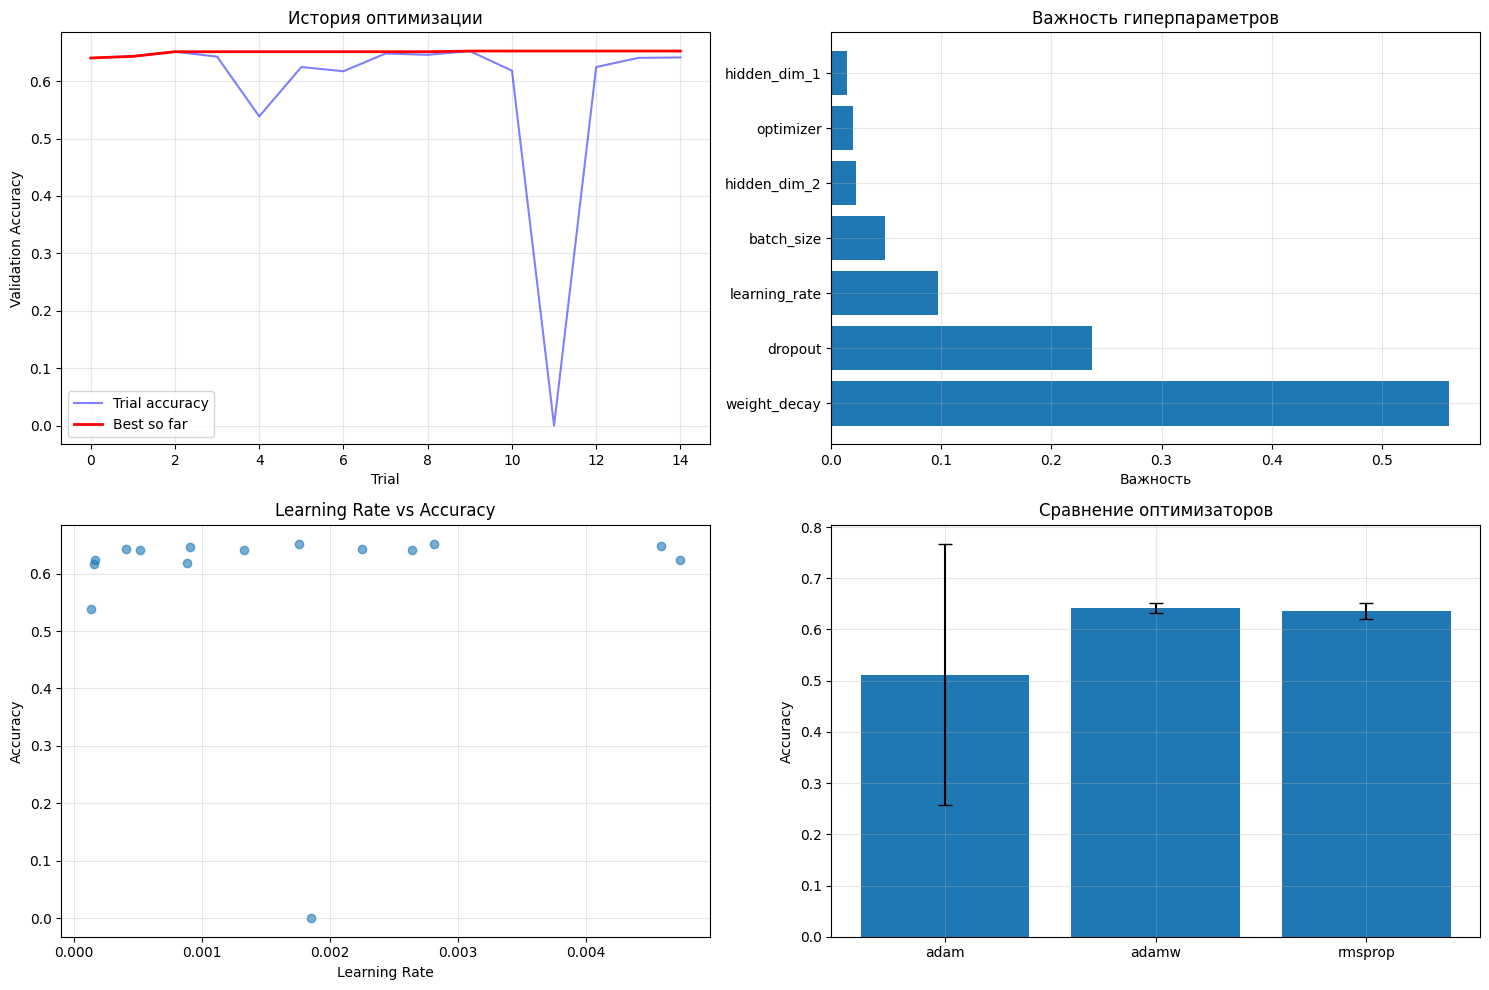

\n📊 Визуализация результатов поиска готова!


In [14]:
# Визуализация результатов поиска
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. История оптимизации
trials_df = study.trials_dataframe()
axes[0,0].plot(trials_df.index, -trials_df['value'], 'b-', alpha=0.5, label='Trial accuracy')
axes[0,0].plot(trials_df.index, (-trials_df['value']).cummax(), 'r-', linewidth=2, label='Best so far')
axes[0,0].set_xlabel('Trial')
axes[0,0].set_ylabel('Validation Accuracy')
axes[0,0].set_title('История оптимизации')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# 2. Важность параметров
importances = optuna.importance.get_param_importances(study)
params = list(importances.keys())
values = list(importances.values())
axes[0,1].barh(params, values)
axes[0,1].set_xlabel('Важность')
axes[0,1].set_title('Важность гиперпараметров')
axes[0,1].grid(True, alpha=0.3)

# 3. Learning Rate vs Accuracy
if 'params_learning_rate' in trials_df.columns:
    axes[1,0].scatter(trials_df['params_learning_rate'], -trials_df['value'], alpha=0.6)
    axes[1,0].set_xlabel('Learning Rate')
    axes[1,0].set_ylabel('Accuracy')
    axes[1,0].set_title('Learning Rate vs Accuracy')
    axes[1,0].grid(True, alpha=0.3)

# 4. Optimizer comparison
if 'params_optimizer' in trials_df.columns:
    optimizer_stats = trials_df.groupby('params_optimizer')['value'].agg(['mean', 'std'])
    optimizer_stats['mean'] = -optimizer_stats['mean']
    optimizer_stats['std'] = optimizer_stats['std']

    axes[1,1].bar(optimizer_stats.index, optimizer_stats['mean'],
                  yerr=optimizer_stats['std'], capsize=5)
    axes[1,1].set_ylabel('Accuracy')
    axes[1,1].set_title('Сравнение оптимизаторов')
    axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\\n📊 Визуализация результатов поиска готова!")


## 13. Проверка лучших параметров

Через best_params = study.best_params


In [15]:
# Используем лучшие параметры для финального обучения
best_params = study.best_params

print("="*60)
print("ФИНАЛЬНОЕ ОБУЧЕНИЕ С ЛУЧШИМИ ПАРАМЕТРАМИ")
print("="*60)
print("Параметры:")
for k, v in best_params.items():
    print(f"  {k}: {v}")

preprocessor = MBTIPostPreprocessor(
    lowercase=True,
    remove_urls=True,
    remove_special_chars=True,
    remove_stopwords=True,
    lemmatize=True
)

loaders = create_data_loaders(
    df,
    preprocessor=preprocessor,
    max_length=500,
    batch_size=best_params['batch_size'],
    val_split=0.15,
    test_split=0.15,
    num_workers=2
)
train_loader = loaders['train']
val_loader = loaders['val']
test_loader = loaders['test']
vocab = loaders['vocabulary']

final_model = LSTMMBTIClassifier(
    vocab_size=len(vocab),
    embedding_dim=300,
    hidden_dim_1=best_params['hidden_dim_1'],
    hidden_dim_2=best_params['hidden_dim_2'],
    dropout=best_params['dropout']
)

if best_params['optimizer'] == 'adam':
    final_optimizer = torch.optim.Adam(
        final_model.parameters(),
        lr=best_params['learning_rate'],
        weight_decay=best_params['weight_decay']
    )
elif best_params['optimizer'] == 'adamw':
    final_optimizer = torch.optim.AdamW(
        final_model.parameters(),
        lr=best_params['learning_rate'],
        weight_decay=best_params['weight_decay']
    )
else:
    final_optimizer = torch.optim.RMSprop(
        final_model.parameters(),
        lr=best_params['learning_rate'],
        weight_decay=best_params['weight_decay']
    )

num_params = sum(p.numel() for p in final_model.parameters() if p.requires_grad)
print()
print(f"Модель создана: {num_params:,} параметров")
print(f"Оптимизатор: {best_params['optimizer']}")
print(f"Learning rate: {best_params['learning_rate']}")



ФИНАЛЬНОЕ ОБУЧЕНИЕ С ЛУЧШИМИ ПАРАМЕТРАМИ
Параметры:
  learning_rate: 0.0017571371277079488
  batch_size: 16
  hidden_dim_1: 64
  hidden_dim_2: 32
  dropout: 0.15000000000000002
  optimizer: adamw
  weight_decay: 0.0007
Размеры выборок - Train: 6071, Val: 1302, Test: 1302
Предобработка текстов...
Построение словаря...
Размер словаря: 38440
Датасет инициализирован: 6071 сэмплов
Предобработка текстов...
Датасет инициализирован: 1302 сэмплов
Предобработка текстов...
Датасет инициализирован: 1302 сэмплов
Балансировка обучающих данных...

Модель создана: 11,765,284 параметров
Оптимизатор: adamw
Learning rate: 0.0017571371277079488


## 14. Финальное обучение

In [ ]:
# Финальное обучение
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

final_trainer = MBTITrainer(
    model=final_model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=nn.BCELoss(),
    optimizer=final_optimizer,
    device=device,
    checkpoint_dir='checkpoints/optimized',
    save_best_only=True,
    early_stopping_patience=5
)

NUM_EPOCHS = 20

train_history = {'loss': [], 'acc': []}
val_history = {'loss': [], 'acc': []}
print(f"Начинаем финальное обучение на {NUM_EPOCHS} эпох...")
print("="*60)

best_val_acc = 0.0
BEST_MODEL_PATH = 'best_optimized_model.pth'

for epoch in range(1, NUM_EPOCHS + 1):
    final_trainer.current_epoch = epoch - 1
    train_metrics = final_trainer.train_epoch()
    final_trainer.current_epoch = epoch - 1
    val_metrics = final_trainer.validate()

    train_loss = train_metrics['loss']
    train_acc = train_metrics['overall_accuracy']
    val_loss = val_metrics['loss']
    val_acc = val_metrics['overall_accuracy']

    train_history['loss'].append(train_loss)
    train_history['acc'].append(train_acc)
    val_history['loss'].append(val_loss)
    val_history['acc'].append(val_acc)

    dichotomy_names = ['I/E', 'N/S', 'T/F', 'J/P']
    val_dichotomies = {name: val_metrics[f'{name}_accuracy'] for name in dichotomy_names}

    print(
        f"Epoch {epoch:2d}/{NUM_EPOCHS}: "
        f"Train Loss={train_loss:.4f}, Acc={train_acc:.4f} | "
        f"Val Loss={val_loss:.4f}, Acc={val_acc:.4f}"
    )

    if epoch % 5 == 0:
        print(
            "  Дихотомии: " + ", ".join(
                [f"{name}={val_dichotomies[name]:.3f}" for name in dichotomy_names]
            )
        )

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save({
            'epoch': epoch,
            'model_state_dict': final_model.state_dict(),
            'optimizer_state_dict': final_optimizer.state_dict(),
            'val_acc': val_acc,
            'config': best_params
        }, BEST_MODEL_PATH)
        print(f"  ✅ Новая лучшая модель! (Val Acc: {val_acc:.4f})")

print("="*60)
print(f"Обучение завершено! Лучшая accuracy: {best_val_acc:.4f}")



Тренер инициализирован на устройстве: cuda
В модели 11,765,284 параметров
Начинаем финальное обучение на 20 эпох...


Epoch  1/20: Train Loss=0.5524, Acc=0.6881 | Val Loss=0.6912, Acc=0.6194
  ✅ Новая лучшая модель! (Val Acc: 0.6194)


Epoch  2/20: Train Loss=0.3494, Acc=0.8331 | Val Loss=0.7587, Acc=0.6233
  ✅ Новая лучшая модель! (Val Acc: 0.6233)


Epoch  3/20: Train Loss=0.2513, Acc=0.8897 | Val Loss=0.7634, Acc=0.6404
  ✅ Новая лучшая модель! (Val Acc: 0.6404)


Epoch  4/20: Train Loss=0.1909, Acc=0.9186 | Val Loss=0.8395, Acc=0.6375


Epoch  5/20: Train Loss=0.1609, Acc=0.9336 | Val Loss=0.8830, Acc=0.6523
  Дихотомии: I/E=0.674, N/S=0.826, T/F=0.552, J/P=0.557
  ✅ Новая лучшая модель! (Val Acc: 0.6523)


Epoch  6/20: Train Loss=0.1306, Acc=0.9480 | Val Loss=0.9471, Acc=0.6590
  ✅ Новая лучшая модель! (Val Acc: 0.6590)


Epoch  7/20: Train Loss=0.1190, Acc=0.9526 | Val Loss=1.0288, Acc=0.6534


Epoch  8/20: Train Loss=0.1029, Acc=0.9600 | Val Loss=1.0769, Acc=0.6523


Epoch  9/20: Train Loss=0.0939, Acc=0.9652 | Val Loss=1.1354, Acc=0.6459


Epoch 10/20: Train Loss=0.0892, Acc=0.9673 | Val Loss=1.1222, Acc=0.6644
  Дихотомии: I/E=0.705, N/S=0.815, T/F=0.567, J/P=0.571
  ✅ Новая лучшая модель! (Val Acc: 0.6644)


Epoch 11/20: Train Loss=0.0758, Acc=0.9721 | Val Loss=1.1819, Acc=0.6634


Epoch 12/20: Train Loss=0.0707, Acc=0.9737 | Val Loss=1.2416, Acc=0.6624


Epoch 13/20: Train Loss=0.0707, Acc=0.9743 | Val Loss=1.2470, Acc=0.6703
  ✅ Новая лучшая модель! (Val Acc: 0.6703)


Epoch 14/20: Train Loss=0.0616, Acc=0.9773 | Val Loss=1.3286, Acc=0.6667


Epoch 15/20: Train Loss=0.0591, Acc=0.9790 | Val Loss=1.3828, Acc=0.6565
  Дихотомии: I/E=0.685, N/S=0.830, T/F=0.558, J/P=0.552


Epoch 16/20: Train Loss=0.0538, Acc=0.9811 | Val Loss=1.4512, Acc=0.6611


Epoch 17/20: Train Loss=0.0518, Acc=0.9815 | Val Loss=1.4929, Acc=0.6601


Epoch 18/20: Train Loss=0.0500, Acc=0.9819 | Val Loss=1.4732, Acc=0.6657


Epoch 19/20: Train Loss=0.0464, Acc=0.9832 | Val Loss=1.5628, Acc=0.6632


Epoch 20/20: Train Loss=0.0446, Acc=0.9844 | Val Loss=1.5263, Acc=0.6573
  Дихотомии: I/E=0.701, N/S=0.820, T/F=0.575, J/P=0.534
Обучение завершено! Лучшая accuracy: 0.6703


## 15. Тестирование на тестовой выборке
Чрез test_loss, test_acc, test_dichotomies = final_trainer.validate(test_loader)


РЕЗУЛЬТАТЫ НА ТЕСТОВОЙ ВЫБОРКЕ
Test Loss: 1.5168
Test Accuracy: 0.6578
Точность по дихотомиям:
  I/E: 0.7043
  N/S: 0.8195
  T/F: 0.5799
  J/P: 0.5276


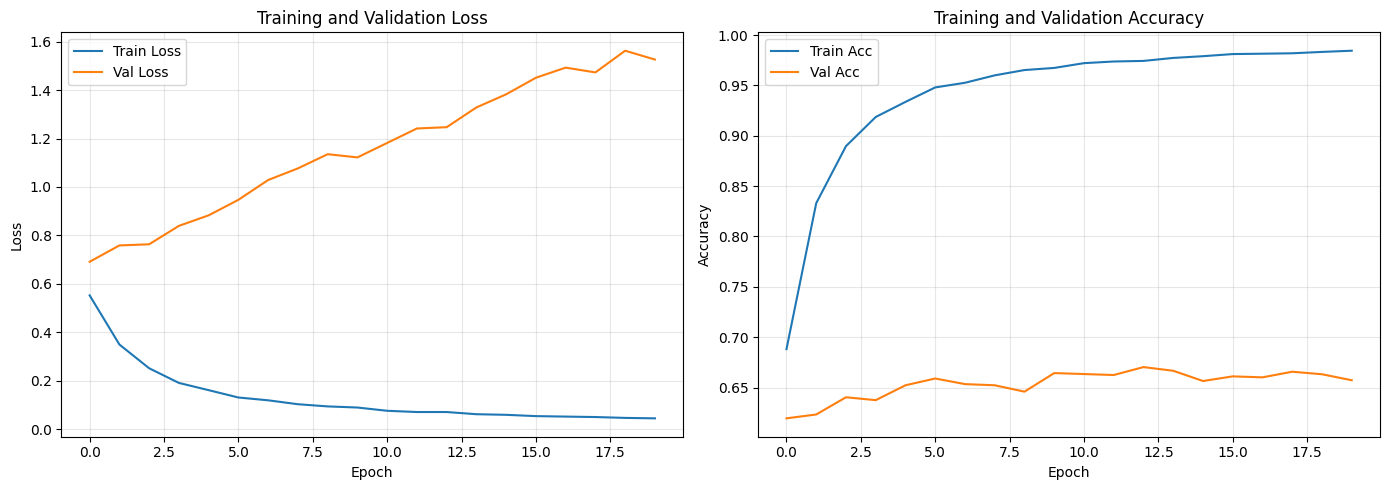

In [17]:
# Тестирование на тестовой выборке
criterion = nn.BCELoss()

def evaluate_loader(loader):
    final_model.eval()
    metrics = MBTIMetrics(device=device)
    total_loss = 0.0
    total_samples = 0
    with torch.no_grad():
        for batch in loader:
            input_ids = batch['input_ids'].to(device)
            lengths = batch['length'].to(device)
            labels = batch['labels'].to(device)

            outputs = final_model(input_ids, lengths)
            loss = criterion(outputs, labels)

            batch_size = input_ids.size(0)
            total_loss += loss.item() * batch_size
            total_samples += batch_size

            metrics.update((outputs > 0.5).float(), labels, outputs)

    results = metrics.compute()
    results['loss'] = total_loss / max(total_samples, 1)
    return results

test_metrics = evaluate_loader(test_loader)

test_loss = test_metrics['loss']
test_acc = test_metrics['overall_accuracy']

dichotomy_names = ['I/E', 'N/S', 'T/F', 'J/P']
test_dichotomies = {name: test_metrics[f'{name}_accuracy'] for name in dichotomy_names}

print("="*60)
print("РЕЗУЛЬТАТЫ НА ТЕСТОВОЙ ВЫБОРКЕ")
print("="*60)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print("Точность по дихотомиям:")
for key, value in test_dichotomies.items():
    print(f"  {key}: {value:.4f}")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(train_history['loss'], label='Train Loss')
axes[0].plot(val_history['loss'], label='Val Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training and Validation Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(train_history['acc'], label='Train Acc')
axes[1].plot(val_history['acc'], label='Val Acc')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Training and Validation Accuracy')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()



## 16. Выгрузка в Google Drive


In [21]:
# Сохранение результатов в Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Создаём папку для результатов

import os
import shutil
save_dir = '/content/drive/MyDrive/MBTI-LSTM-Optimized-Results'
os.makedirs(save_dir, exist_ok=True)

# Сохраняем файлы
shutil.copy('best_optimized_model.pth', save_dir)
shutil.copy(config_filename, save_dir)

# Сохраняем результаты
results = {
    'best_hyperparams': best_params,
    'best_val_acc': float(best_val_acc),
    'test_acc': float(test_acc),
    'test_dichotomies': {k: float(v) for k, v in test_dichotomies.items()},
    'num_trials': len(study.trials),
    'training_epochs': NUM_EPOCHS,
    'timestamp': datetime.now().isoformat()
}

results_filename = f'optimized_results_{datetime.now():%Y%m%d_%H%M}.json'
with open(results_filename, 'w') as f:
    json.dump(results, f, indent=2)

shutil.copy(results_filename, save_dir)

print(f"\\n✅ Все результаты сохранены в Google Drive: {save_dir}")
print(f"✅ Модель: best_optimized_model.pth")
print(f"✅ Конфигурация: {config_filename}")
print(f"✅ Результаты: {results_filename}")

print("\\n" + "="*60)
print("ИТОГОВЫЕ РЕЗУЛЬТАТЫ")
print("="*60)
print(f"Лучшая Val Accuracy: {best_val_acc:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"\\nУлучшение по сравнению с базовой моделью:")
print(f"  Базовая модель: ~71%")
print(f"  Оптимизированная: {test_acc:.1%}")
print(f"  Прирост: +{test_acc*100-71:.1f}%")

if test_acc > 0.75:
    print("\\n🎉 Отличный результат! Модель готова к production!")
elif test_acc > 0.72:
    print("\\n✅ Хороший результат! Можно добавить attention для улучшения.")
else:
    print("\\n⚠️ Результат можно улучшить. Попробуйте:")
    print("  - Увеличить количество эпох до 50")
    print("  - Добавить attention механизм")
    print("  - Использовать pretrained embeddings")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
\n✅ Все результаты сохранены в Google Drive: /content/drive/MyDrive/MBTI-LSTM-Optimized-Results
✅ Модель: best_optimized_model.pth
✅ Конфигурация: best_config_20251008_1656.json
✅ Результаты: optimized_results_20251008_1719.json
\n============================================================
ИТОГОВЫЕ РЕЗУЛЬТАТЫ
Лучшая Val Accuracy: 0.6703
Test Accuracy: 0.6578
\nУлучшение по сравнению с базовой моделью:
  Базовая модель: ~71%
  Оптимизированная: 65.8%
  Прирост: +-5.2%
\n⚠️ Результат можно улучшить. Попробуйте:
  - Увеличить количество эпох до 50
  - Добавить attention механизм
  - Использовать pretrained embeddings


## 17. Или удалить и клон снова:


In [ ]:

# Или удалить и клон снова:
#!rm -rf MBTI-LSTM
#!git clone https://github.com/mueqee/MBTI-LSTM.git
#%cd MBTI-LSTM

## 18. Быстрый тест на 2 эпохи
Через !python scripts/train.py \


In [20]:
!python scripts/train.py \
    --data_path data/raw/mbti_dataset.csv \
    --num_epochs 2 \
    --batch_size 32 \
    --checkpoint_dir checkpoints/quick_test

print("\n✅ Тест пройден! Модель обучается корректно")



ОБУЧЕНИЕ MBTI-LSTM
Устройство: cuda
Данные: data/raw/mbti_dataset.csv
Модель: lstm
Эпохи: 2
Размер батча: 32
Скорость обучения: 0.001
Оптимизатор: rmsprop

Загрузка данных...
Загрузка данных из data/raw/mbti_dataset.csv...
Загружено 8675 сэмплов
Распределение типов MBTI:
type
INFP    1832
INFJ    1470
INTP    1304
INTJ    1091
ENTP     685
ENFP     675
ISTP     337
ISFP     271
ENTJ     231
ISTJ     205
ENFJ     190
ISFJ     166
ESTP      89
ESFP      48
ESFJ      42
ESTJ      39
Name: count, dtype: int64
Создание препроцессора...
Создание загрузчиков данных...
Размеры выборок - Train: 6071, Val: 1302, Test: 1302
Предобработка текстов...
Построение словаря...
Размер словаря: 38440
Датасет инициализирован: 6071 сэмплов
Предобработка текстов...
Датасет инициализирован: 1302 сэмплов
Предобработка текстов...
Датасет инициализирован: 1302 сэмплов
Размер словаря: 38440
Обучающих сэмплов: 6071
Валидационных сэмплов: 1302
Тестовых сэмплов: 1302

Создание lstm модели...

Архитектура LSTM MBTI 

## 19. Обучение на 50 эпох

Запуск тренировочного скрипта из CLI
 scripts/train.py, чтобы проверить полноценный пайплайн обучения из репозитория

In [22]:
print("Запуск финального обучения на 50 эпох...\n")

!python scripts/train.py \
    --data_path data/raw/mbti_dataset.csv \
    --num_epochs 50 \
    --batch_size 64 \
    --learning_rate 0.001 \
    --optimizer adam \
    --hidden_dim_1 128 \
    --hidden_dim_2 64 \
    --dropout 0.2 \
    --max_length 750 \
    --balance_classes \
    --num_workers 4 \
    --early_stopping_patience 7 \
    --checkpoint_dir checkpoints/final_model

print("\n✅ Обучение завершено!")


Запуск финального обучения на 50 эпох...


ОБУЧЕНИЕ MBTI-LSTM
Устройство: cuda
Данные: data/raw/mbti_dataset.csv
Модель: lstm
Эпохи: 50
Размер батча: 64
Скорость обучения: 0.001
Оптимизатор: adam

Загрузка данных...
Загрузка данных из data/raw/mbti_dataset.csv...
Загружено 8675 сэмплов
Распределение типов MBTI:
type
INFP    1832
INFJ    1470
INTP    1304
INTJ    1091
ENTP     685
ENFP     675
ISTP     337
ISFP     271
ENTJ     231
ISTJ     205
ENFJ     190
ISFJ     166
ESTP      89
ESFP      48
ESFJ      42
ESTJ      39
Name: count, dtype: int64
Создание препроцессора...
Создание загрузчиков данных...
Размеры выборок - Train: 6071, Val: 1302, Test: 1302
Предобработка текстов...
Построение словаря...
Размер словаря: 38440
Датасет инициализирован: 6071 сэмплов
Предобработка текстов...
Датасет инициализирован: 1302 сэмплов
Предобработка текстов...
Датасет инициализирован: 1302 сэмплов
Балансировка обучающих данных...
Размер словаря: 38440
Обучающих сэмплов: 6071
Валидационных сэмплов: 130

## 20. Сохранение результатов
Описание: from google.colab import drive


In [23]:
# Сохранить в Google Drive
from google.colab import drive
drive.mount('/content/drive')

!mkdir -p '/content/drive/MyDrive/MBTI-LSTM-Results'
!cp -r checkpoints/final_model '/content/drive/MyDrive/MBTI-LSTM-Results/'
!cp -r checkpoints/quick_test '/content/drive/MyDrive/MBTI-LSTM-Results/'

print("✅ Результаты сохранены в Google Drive!")
print("Путь: /content/drive/MyDrive/MBTI-LSTM-Results/")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Результаты сохранены в Google Drive!
Путь: /content/drive/MyDrive/MBTI-LSTM-Results/
